In [1]:
# Step-2:
#### 1. Image Contrast
#### 2. Data Split (Train(80), Validation(20))
#### 3. Transfer learning

In [1]:
pip install opencv-python --user

Note: you may need to restart the kernel to use updated packages.Collecting opencv-python
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)



You should consider upgrading via the 'C:\Users\v4run\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import tensorflow as tf
import keras
from imageContrast import img_cont
from skimage import exposure
from pylab import *
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from imageCropping import crop_img

In [3]:
trainingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/TrainingDataset'

In [4]:
def imgContrastPreprocess(images, labels):
    equalized_images = tf.map_fn(lambda img: tf.py_function(img_cont, [img], Tout=tf.float32), images, fn_output_signature=tf.float32)
    return equalized_images, labels

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='training'
)

Found 9625 files belonging to 2 classes.
Using 7700 files for training.


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation'
)

Found 9625 files belonging to 2 classes.
Using 1925 files for validation.


In [7]:
trainDataset = train_data.map(imgContrastPreprocess).repeat()

In [8]:
validDataset = val_data.map(imgContrastPreprocess)

In [9]:
# Model Structure
# parallel branches and dilated convolution using the Keras Functional API

In [14]:
input_img = Input(shape=(256,256,3))

conv1 = Conv2D(32,(3,3), activation = 'relu', padding='same')(input_img)
conv1 = MaxPooling2D((2,2), padding='same')(conv1)

conv2 = Conv2D(64,(3,3), activation = 'relu', padding='same')(conv1)
conv2 = MaxPooling2D((2,2), padding='same')(conv2)

conv3 = Conv2D(128,(3,3), activation = 'relu', padding='same')(conv2)
conv3 = MaxPooling2D((2,2), padding='same')(conv3)

# Parallel branches
pbranch1 = Conv2D(256,(3,3), activation = 'relu', padding='same')(conv3)
pbranch2 = Conv2D(256,(5,5), activation = 'relu', padding='same')(conv3)
pbranch3 = Conv2D(256,(7,7), activation = 'relu', padding='same')(conv3)

# Concatenate
concatenateBranch = concatenate([pbranch1,pbranch2,pbranch3], axis=1) #fix this to 3 or -1

# Dilated convulation
dilatedConv = Conv2D(256,(3,3), activation = 'relu', padding='same', dilation_rate=2)(concatenateBranch)
dilatedConv = MaxPooling2D((2,2),padding = 'same')(dilatedConv)

# Flatten and fully connected layers
flat = Flatten()(dilatedConv)
dense1 = Dense(256,activation='relu')(flat)
dense2 = Dense(1,activation='sigmoid')(dense1)

model = Model(inputs=input_img, outputs=dense2)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])
earlyStopping = EarlyStopping(monitor='val_auc', patience=10, verbose=1, mode='max')
checkPoint = ModelCheckpoint(
    'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel2.h5',
    monitor = 'val_auc',
    verbose = 1,
    save_best_only=True,
    mode='max'
)
history = model.fit(
    trainDataset,
    steps_per_epoch=floor(7700//32),
    epochs=100,
    validation_data=validDataset,
    validation_steps=floor(1925//32),
    callbacks=[earlyStopping,checkPoint]
)

loss, accuracy = model.evaluate(validDataset,steps=floor(1925//32))

Epoch 1/100
240/240 [==============================] - ETA: 0s - loss: 0.7104 - auc: 0.6195
Epoch 1: val_auc improved from -inf to 0.74188, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\fourLayerModel2.h5
240/240 [==============================] - 1471s 6s/step - loss: 0.7104 - auc: 0.6195 - val_loss: 0.5667 - val_auc: 0.7419
Epoch 2/100
240/240 [==============================] - ETA: 0s - loss: 0.4665 - auc: 0.8313
Epoch 2: val_auc improved from 0.74188 to 0.90274, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\fourLayerModel2.h5
240/240 [==============================] - 1498s 6s/step - loss: 0.4665 - auc: 0.8313 - val_loss: 0.4498 - val_auc: 0.9027
Epoch 3/100
240/240 [==============================] - ETA: 0s - loss: 0.3689 - auc: 0.9068
Epoch 3: val_auc improved from 0.90274 to 0.93316, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\fourLayerModel2.h5
240/240 [=========================

In [15]:
best_epochLocation = history.history['val_auc'].index(max(history.history['val_auc']))
best_epochLocation

5

In [16]:
best_history = {key: values[:best_epochLocation + 1] for key, values in history.history.items()}
best_history

{'loss': [0.7103872299194336,
  0.4664662182331085,
  0.36891305446624756,
  0.29818952083587646,
  0.26992082595825195,
  0.24942603707313538],
 'auc': [0.6195219159126282,
  0.8312795162200928,
  0.9068351984024048,
  0.9396439790725708,
  0.949993371963501,
  0.9571464657783508],
 'val_loss': [0.566656231880188,
  0.44981613755226135,
  0.3202095329761505,
  0.30653125047683716,
  0.3157605528831482,
  0.2676265835762024],
 'val_auc': [0.7418783903121948,
  0.9027372002601624,
  0.933159589767456,
  0.9473451972007751,
  0.9498438835144043,
  0.9541935920715332]}

In [15]:
model.save('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel.h5')

In [17]:
savedModel = tf.keras.models.load_model('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel2.h5')

In [18]:
acc = best_history['auc']
loss = best_history['loss']
val_acc = best_history['val_auc']
val_loss = best_history['val_loss']

In [19]:
epoch = range(1, len(acc)+1)

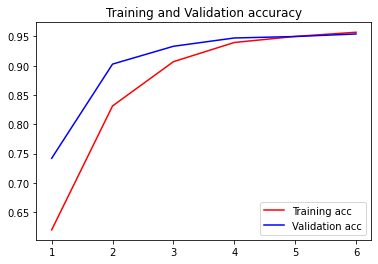

In [20]:
plt.plot(epoch, acc, 'r', label = 'Training acc')
plt.plot(epoch, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

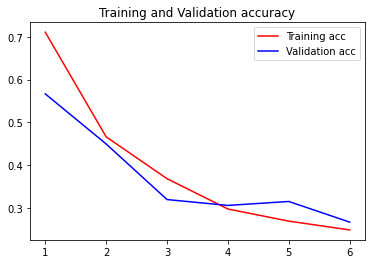

In [21]:
plt.plot(epoch, loss, 'r', label = 'Training acc')
plt.plot(epoch, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

In [22]:
# Test Data

In [23]:
testingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2'

In [24]:
test_data = tf.keras.utils.image_dataset_from_directory(
    testingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32
)

Found 3553 files belonging to 2 classes.


In [25]:
#crop Data

In [26]:
def imgCropPreprocess(images,labels):
    cropped_images = tf.map_fn(lambda img: tf.py_function(crop_img, [img], Tout=tf.float32), images)
    return cropped_images,labels

In [27]:
testCropped_data = test_data.map(imgCropPreprocess)

In [28]:
a = testCropped_data.as_numpy_iterator()

In [29]:
img, label = a.next()

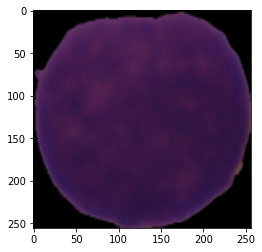

In [30]:
imshow(img[0])

In [31]:
testCont_data = testCropped_data.map(imgContrastPreprocess)

In [32]:
saved_model = tf.keras.models.load_model('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel2.h5')

In [33]:
# prediction

In [34]:
y_predict = saved_model.predict(testCont_data)

112/112 [==============================] - 214s 2s/step


In [35]:
y_predict_binary = (y_predict>0.5).astype(int)

In [36]:
y_pred = np.round(y_predict).flatten()

In [37]:
y_predict_binary

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [38]:
y_pred

array([0., 0., 0., ..., 0., 0., 1.], dtype=float32)

In [39]:
y_true = np.concatenate([y for x, y in testCont_data], axis=0)

In [40]:
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)
f1Score = f1_score(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1_score: {f1Score:.4f}')

Precision: 0.6844
Recall: 0.0838
f1_score: 0.1494


In [41]:
confusionMatrix = confusion_matrix(y_true, y_predict_binary)
print(confusionMatrix)

[[1001   95]
 [2251  206]]


In [42]:
layer_names = [layer.name for layer in saved_model.layers if 'conv' in layer.name]
visualize_model = Model(inputs=saved_model.inputs, outputs=[saved_model.get_layer(name).output for name in layer_names])

In [43]:
a = testCont_data.as_numpy_iterator()

In [44]:
img1, label1 = a.next()

In [45]:
img10,label10 = img1[0],label1[0]

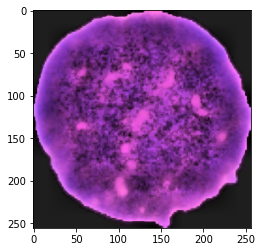

In [46]:
imshow(img10)

In [47]:
label10

1

In [48]:
img10 = np.expand_dims(img10,axis=0)

In [49]:
(saved_model.predict(img10)>0.5).astype(int)

1/1 [==============================] - 0s 177ms/step


array([[0]])

In [50]:
activations = visualize_model(img10)

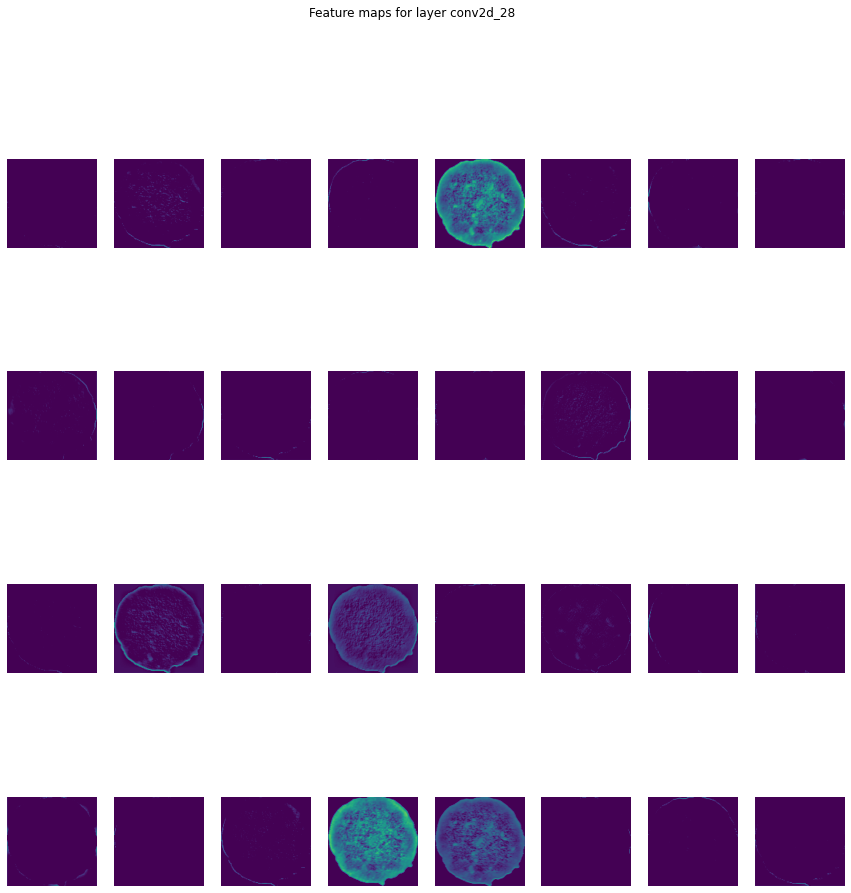

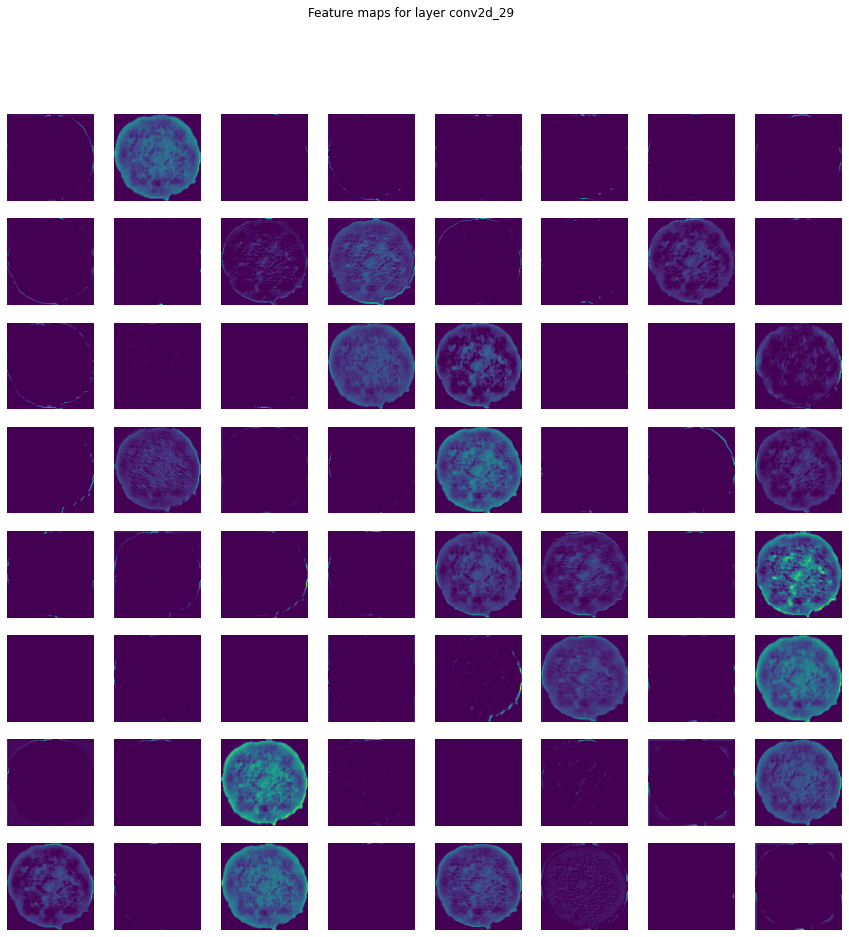

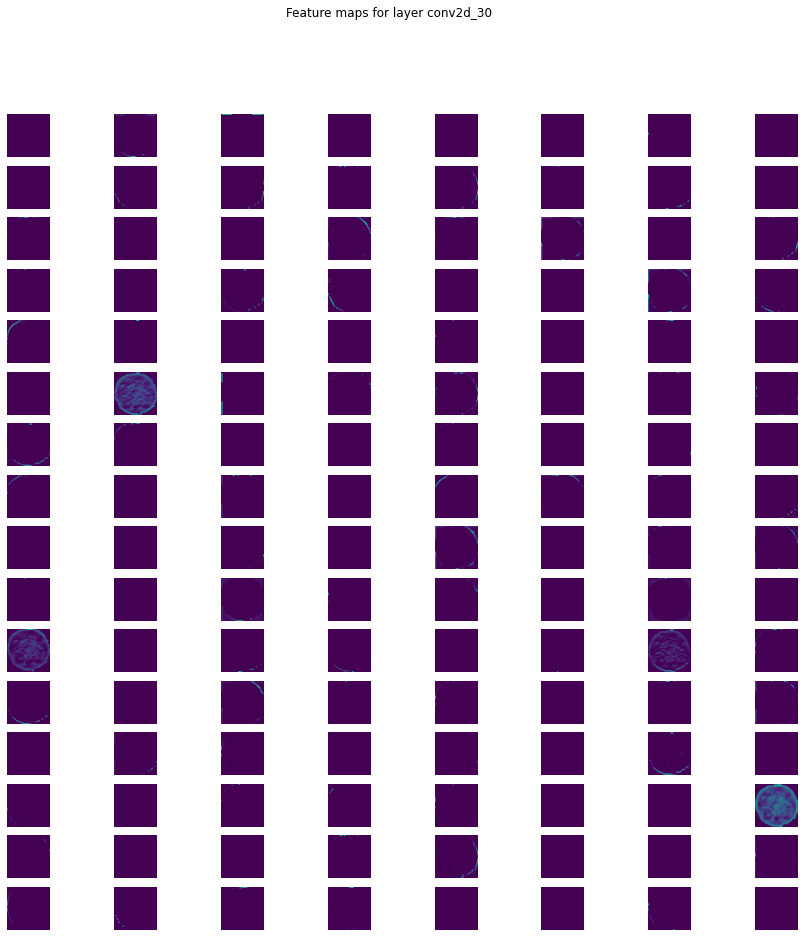

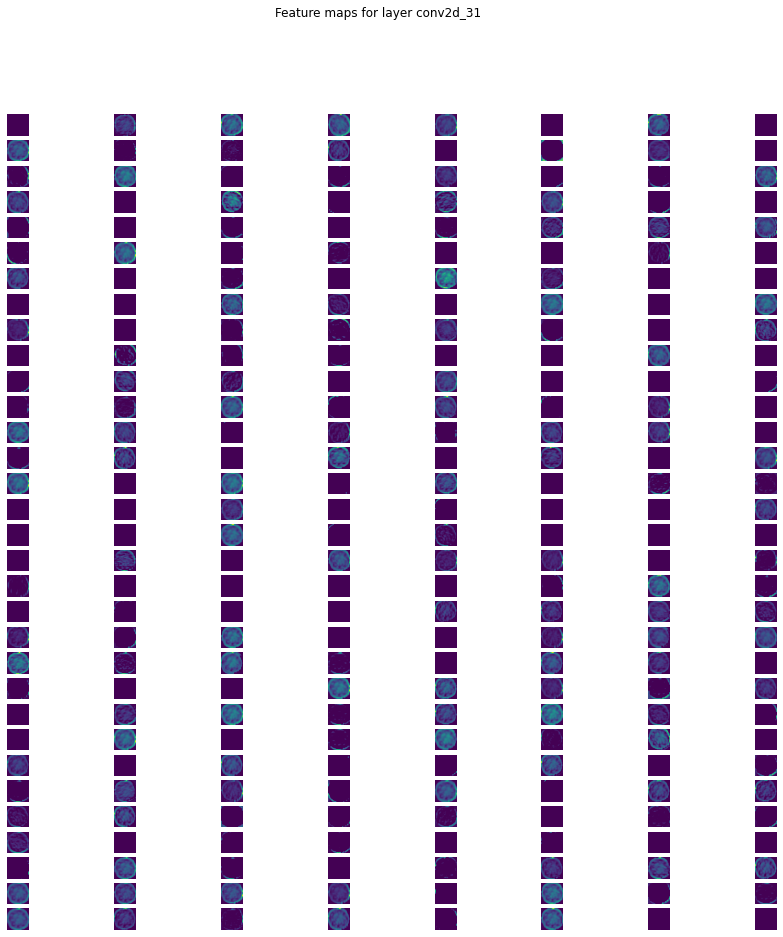

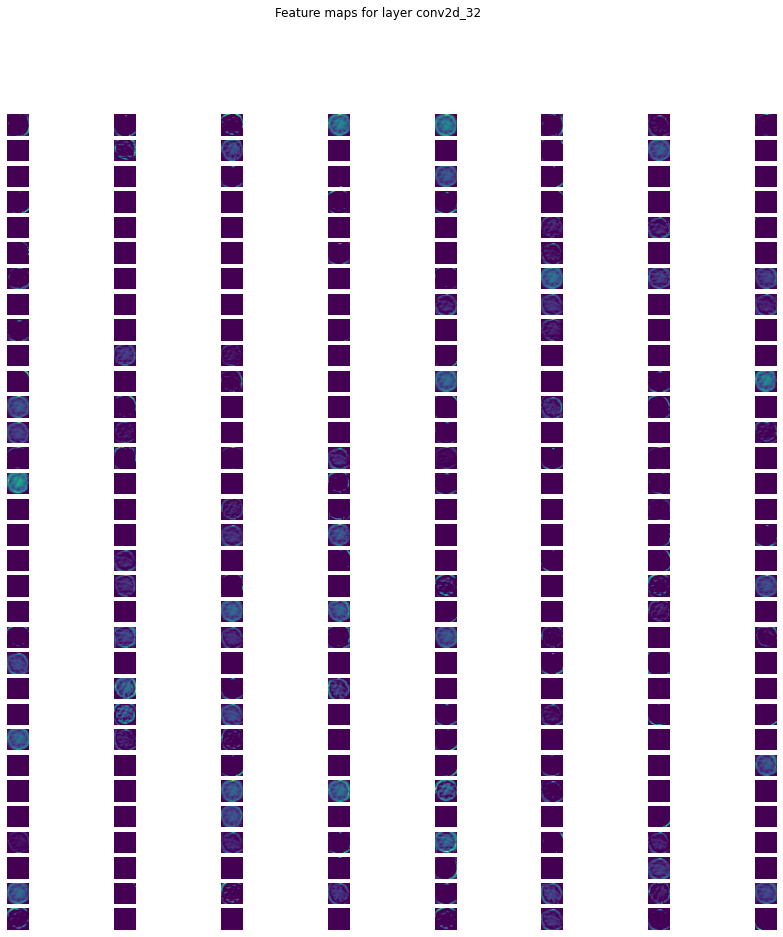

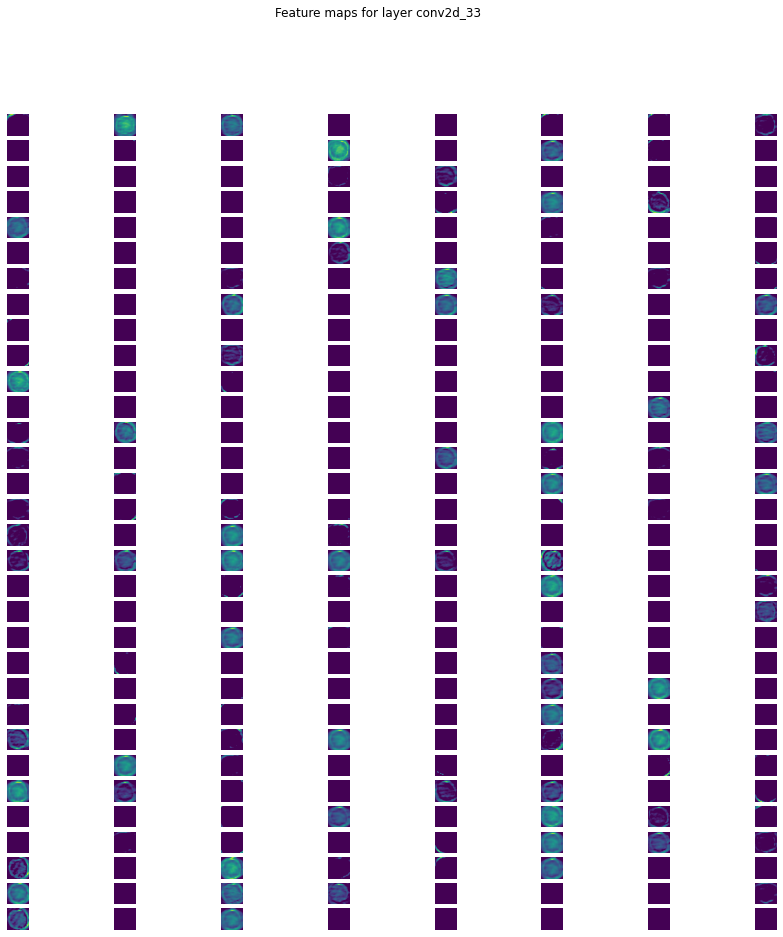

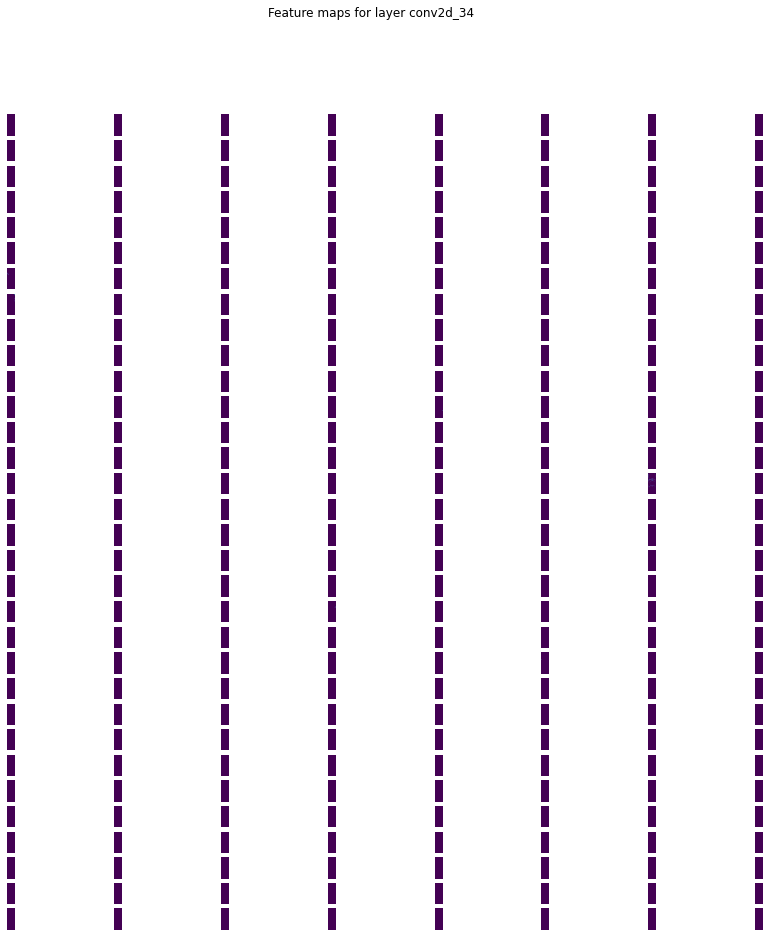

In [51]:
def display_feature_maps(activations, layer_names):
    for i, activation in enumerate(activations):
        layer_name = layer_names[i]
        num_filters = activation.shape[-1]

        # Calculate the number of rows and columns for the grid
        no_cols = 8
        grid_rows = num_filters // no_cols

        fig, axes = plt.subplots(grid_rows, no_cols, figsize=(15, 15))
        fig.suptitle(f"Feature maps for layer {layer_name}")

        for j in range(num_filters):
            ax = axes[j // no_cols, j % no_cols]
            ax.imshow(activation[0, :, :, j], cmap='viridis')
            ax.axis('off')

        plt.show()

# Call the function with the activations and layer names
display_feature_maps(activations, layer_names)